In [1]:
import numpy as np

In [2]:
import riemann

# RJMCMC Example with univariate mixture of Gaussians

In [3]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from dbo import param_serial, gmm_utils

In [4]:
gmm = gmm_utils.GMM(weights=[0.4,0.6], means=[[0.], [0.9]], covariances=[[[0.01]], [[0.01]]])

In [5]:
import matplotlib.pyplot as plt

query_x = np.linspace(-1,2,100)[:,None]
pdf_query_x = gmm.density(gmm_utils.ensure_torch(query_x)).numpy()

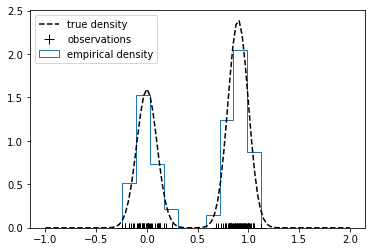

In [6]:
n_obs = 100
obs = gmm.sample(n_obs)

plt.plot(query_x, pdf_query_x, 'k--', label="true density")
plt.plot(obs.numpy(), np.zeros(len(obs)), 'k+', ms=10, label="observations")
plt.hist(obs.numpy(), density=True, histtype='step', label="empirical density")
plt.legend()

## Model

In [7]:
from riemann.proposals import rj_proposals, rj_generic

In [8]:
import importlib
importlib.reload(rj_proposals)

<module 'riemann.proposals.rj_proposals' from '/home/rafael/Projects/riemann/riemann/proposals/rj_proposals.py'>

In [9]:
true_cov_factors = torch.cholesky(gmm.covariances)
true_params = param_serial.GMMParameters.serialise(gmm.weights, gmm.means, true_cov_factors)
true_k = len(gmm.weights)
true_state = rj_proposals.RJState(true_params.numpy(), true_k)

In [10]:
max_n_comp = 3
dim = int(len(true_params)/len(gmm.weights))
g_means = [np.zeros(dim*n) for n in range(1,max_n_comp+1)]
g_covs = [0.1*np.eye(dim*n) for n in range(1,max_n_comp+1)]
generic_map = rj_generic.GenericMapping(g_means, g_covs)

In [11]:
jump_prop = rj_proposals.JumpProposal(generic_map, rj_generic.GenericMatchingProp(dim))

In [12]:
no_jump_ratio = 1.1
move_prop = rj_generic.MoveProp(max_n_comp, no_jump_ratio)

In [13]:
rj_prop = rj_proposals.RJProposal(move_prop, jump_prop, rj_generic.RandomWalk(0.01))

In [14]:
n_samples = 100
sample = rj_proposals.RJState(np.random.rand(3), 1)
for i in range(n_samples):
    sample, _ = rj_prop.propose(sample)
    print(sample.param)

[ 0.30663435  0.01157707  0.73797508 -0.09059322 -0.08211036  0.00967441]
[ 0.30663435  0.01157707  0.73797508 -0.09059322 -0.08211036  0.00967441
  0.06673573 -0.00511496 -0.11807678]
[ 0.31040828  0.02841626  0.74931694 -0.07739339 -0.07164254  0.01625203
  0.06016221 -0.00465779 -0.1089595 ]
[0.31040828 0.02841626 0.74931694]
[ 0.31040828  0.02841626  0.74931694  0.05342671  0.14357039 -0.08295556
 -0.01387458 -0.04518844  0.01462145]
[ 0.31034929  0.02813055  0.75527288  0.06489942  0.14554277 -0.05925171
 -0.02007473 -0.03077906  0.02881939]
[0.31034929 0.02813055 0.75527288]
[ 3.10349288e-01  2.81305471e-02  7.55272878e-01  1.10654942e-01
 -6.50868000e-02  1.00319165e-01 -9.00438143e-02 -3.42354841e-02
  7.49802616e-04]
[0.31034929 0.02813055 0.75527288]
[ 0.31034929  0.02813055  0.75527288 -0.10007257 -0.19836539  0.01533707]
[ 0.31034929  0.02813055  0.75527288 -0.10007257 -0.19836539  0.01533707
 -0.00770307 -0.09289956  0.24038508]
[ 0.31034929  0.02813055  0.75527288 -0.1000

In [15]:
class RJGMModel(riemann.Model):
    def __init__(self, data, k_prior, precision_prior):
        self.data = data
        d = data.shape[-1]
        self.k_prior = k_prior
        self.sample_mean = data.mean(axis=0)
        self.sample_covariance = torch.tensor(np.cov(data.T), dtype=torch.get_default_dtype()).view(d,d)
        self.means_prior = torch.distributions.MultivariateNormal(self.sample_mean, 
                                                             covariance_matrix=self.sample_covariance)
        self.precision_prior = precision_prior
    
    @staticmethod
    def transform_param(param, n_comp):
        weights, means, covariances = param_serial.GMMParameters.deserialise(
            torch.tensor(param, dtype=torch.get_default_dtype()), n_comp)
        weights = weights/weights.sum()
        covariances = torch.matmul(covariances, covariances.transpose(-2, -1))
        return weights, means, covariances
        
    def log_likelihood(self, state):
        candidate_gmm = gmm_utils.GMM(*self.transform_param(state.param, state.idx))
        return candidate_gmm.density(self.data).log().sum().item()
    
    def log_prior(self, state):
        k = state.idx # number of mixture components
        candidate = gmm_utils.GMM(*self.transform_param(state.param, state.idx))
        log_p_k = self.k_prior.log_prob(gmm_utils.ensure_torch(k-1)).item()
        log_p_w = torch.distributions.Dirichlet(torch.ones([k])).log_prob(candidate.weights.view(-1)).item()
        log_p_means = self.means_prior.log_prob(candidate.means).sum().item()
        log_p_precision = self.precision_prior.log_prob(1./candidate.covariances).sum().item() # Assuming 1-D data!
#         print(log_p_k, log_p_w, log_p_means, log_p_precision)
        return log_p_k + log_p_w + log_p_means + log_p_precision

In [16]:
model = RJGMModel(obs, k_prior = torch.distributions.Geometric(torch.tensor(.4)),
                 precision_prior=torch.distributions.Gamma(concentration=100., rate=1.))

In [17]:
initial_n_comp = 1
initial_state = rj_proposals.RJState(np.random.rand(initial_n_comp*dim), initial_n_comp)
rj_sampler = riemann.Sampler(model, rj_prop, initial_state)
rj_sampler.run(1000)

In [18]:
from tqdm import trange

n_samples = 10000
samples = [None]*n_samples
for i in trange(n_samples):
    state, logp = rj_sampler.sample()
    samples[i] = state

100%|██████████| 10000/10000 [00:15<00:00, 631.53it/s]


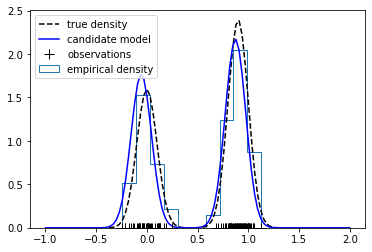

In [19]:
pdf_query_x = gmm.density(gmm_utils.ensure_torch(query_x)).numpy()
candidate_gmm = gmm_utils.GMM(*model.transform_param(state.param, state.idx))
candidate_query_x = candidate_gmm.density(gmm_utils.ensure_torch(query_x)).numpy()

plt.plot(query_x, pdf_query_x, 'k--', label="true density")
plt.plot(query_x, candidate_query_x,'b-', label="candidate model")
plt.plot(obs.numpy(), np.zeros(len(obs)), 'k+', ms=10, label="observations")
plt.hist(obs.numpy(), density=True, histtype='step', label="empirical density")
plt.legend()

<StemContainer object of 3 artists>

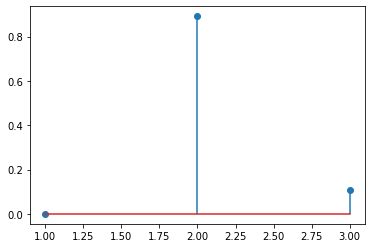

In [20]:
k_samples = [s.idx for s in samples]
counts,_ = np.histogram(k_samples, range=[1,max_n_comp], bins=max_n_comp)

plt.stem(np.arange(1,max_n_comp+1), counts/counts.sum(), use_line_collection=True)